# Project: Best-value Smartphone Data Analysis

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Association Rules

In [2]:
# Generate association rules from frequent itemsets
def assoc_rules(data, m_sup, m_thr):
    
    # Transaction Encoder to convert data into a one-hot (n-dimension) encoded NumPy array
    te = TransactionEncoder()
    te_data = te.fit(data).transform(data)
    pr = pd.DataFrame(te_data,columns=te.columns_)

    # Apriori function: to extract frequent itemsets for association rule mining
    # min_support: Minimum support threshold for the frequent itemsets
    freq_items = apriori(pr, min_support = m_sup, use_colnames = True, verbose = 1)

    # Association rule mining
    # Function to generate association rules from frequent itemsets
    # min_threshold: Minimum threshold for the association rules
    pr_ar = association_rules(freq_items, metric = "confidence", min_threshold = m_thr)
    return freq_items, pr_ar

## KMeans Algorithm/Clustering

In [3]:
def rsserr(a,b):
    '''
    Calculate the root of sum of squared errors. 
    a and b are numpy arrays
    '''
    return np.square(np.sum((a-b)**2))

def initiate_centroids(k, dset):
    '''
    Select k data points as centroids
    k: number of centroids
    dset: pandas dataframe
    '''
    centroids = dset.sample(k)
    return centroids

def centroid_assignation(dset, centroids):
    '''
    Given a dataframe `dset` and a set of `centroids`, we assign each
    data point in `dset` to a centroid. 
    - dset - pandas dataframe with observations
    - centroids - pa das dataframe with centroids
    '''
    k = centroids.shape[0]
    n = dset.shape[0]
    assignation = []
    assign_errors = []

    for obs in range(n):
        # Estimate error
        all_errors = np.array([])
        for centroid in range(k):
            err = rsserr(centroids.iloc[centroid, :], dset.iloc[obs,:])
            all_errors = np.append(all_errors, err)

        # Get the nearest centroid and the error
        nearest_centroid =  np.where(all_errors==np.amin(all_errors))[0].tolist()[0]
        nearest_centroid_error = np.amin(all_errors)

        # Add values to corresponding lists
        assignation.append(nearest_centroid)
        assign_errors.append(nearest_centroid_error)

    return assignation, assign_errors

def kmeans(dset, k=2, tol=1e-4):
    '''
    K-means implementationd for a 
    `dset`:  DataFrame with observations
    `k`: number of clusters, default k=2
    `tol`: tolerance=1E-4
    '''
    # Let us work in a copy, so we don't mess the original
    working_dset = dset.copy()
    # We define some variables to hold the error, the 
    # stopping signal and a counter for the iterations
    err = []
    goahead = True
    j = 0
    
    # Step 2: Initiate clusters by defining centroids 
    centroids = initiate_centroids(k, dset)

    while(goahead):
        # Step 3 and 4 - Assign centroids and calculate error
        working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids) 
        err.append(sum(j_err))
        
        # Step 5 - Update centroid position
        centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)

        # Step 6 - Restart the iteration
        if j>0:
            # Is the error less than a tolerance (1E-4)
            if err[j-1]-err[j]<=tol:
                goahead = False
        j+=1

    working_dset['centroid'], j_err = centroid_assignation(working_dset, centroids)
    centroids = working_dset.groupby('centroid').agg('mean').reset_index(drop = True)
    return working_dset['centroid'], j_err, centroids

## My Functions

In [4]:
# Function to convert Indian Rupees to Euros and round to 2 decimal places
def inr_to_euro(price_inr, exchange_rate=0.011):
    # Remove the currency symbol and commas and convert to float
    price_inr = float(price_inr.replace('₹', '').replace(',', '').strip()) 
    # Convert to Euros from Indian Rupees
    price_euro = price_inr * exchange_rate
    # Round to 2 decimal places
    return round(price_euro, 2)

# Function to extract the required information for processor column
def extract_processor_info(processor):
    parts = processor.split(',')  # Split the string by comma (processor, core, clock speed)

    # Remove the word "Processor" if found in any part 
    cleaned_parts = []
    for part in parts:
        cleaned_part = part.replace('Processor', '').strip()
        cleaned_parts.append(cleaned_part)
    parts = cleaned_parts
    
    processor_type = parts[0].strip()
    # if there is a second part, extract the core type
    if len(parts) > 1:
        core_type = parts[1].strip()
    else:
        core_type = 'N/A'
    # if there is a third part, extract the clock speed
    if len(parts) > 2:
        clock_speed = parts[2].strip()
    else:
        clock_speed = 'N/A'
    return processor_type, core_type, clock_speed

# Function to extract the required information for ram column
def extract_ram_info(ram):
    parts = ram.split(',')  # Split the string by comma (ram, storage type)

    # Remove the word "inbuilt" if found in any part
    cleaned_parts = []
    for part in parts:
        cleaned_part = part.replace('inbuilt', '')
        cleaned_parts.append(cleaned_part)
    parts = cleaned_parts
    
    ram_type = parts[0].strip()
    # if there is a second part, extract the storage type
    if len(parts) > 1:
        storage_type = parts[1].strip()
    else:
        storage_type = 'N/A'
    return ram_type, storage_type

def one_hot_enco_proc(df):
    # Extracting info into a list of tuples and appending to data
    data = []
    for p in df['processor']:
        info = extract_processor_info(p)
        data.append(info)

    # Create new dataframe with three processor columns
    df_proc = pd.DataFrame(data, columns=['processor_type', 'core_type', 'clock_speed'])

    # Stripping additional spaces around the processor type
    df_proc['processor_type'] = df_proc['processor_type'].str.strip().str.replace('  ', ' ')

    # add the new cols to the original dataframe (df)
    df[['processor_type', 'core_type', 'clock_speed']] = df_proc

    # Convert columns to integer codes (One hot encoding - 1 dimension)
    # pd.factorize() returns a tuple of two values
    # [0]: Return the codes [1]: Return the unique values
    # We only need the codes
    df['processor_type_code'] = pd.factorize(df['processor_type'])[0] 
    df['core_type_code'] = pd.factorize(df['core_type'])[0]
    df['clock_speed_code'] = pd.factorize(df['clock_speed'])[0]
    return df

def one_hot_enco_ram(df):
    # Extracting info into a list of tuples and appending to data
    data = []
    for p in df['ram']:
        info = extract_ram_info(p)
        data.append(info)

     # Create new dataframe with the two cols (ram_type, storage_type)
    df_ram = pd.DataFrame(data, columns=['ram_type', 'storage_type'])

    # add the two new cols to the original dataframe (df)
    df[['ram_type','storage_type']] = df_ram

    # Convert columns to integer codes (One hot encoding - 1 dimension)
    # pd.factorize() returns a tuple of two values
    # [0]: Return the codes [1]: Return the unique values
    # We only need the codes 
    df['ram_type_code'] = pd.factorize(df['ram_type'])[0] 
    df['storage_type_code'] = pd.factorize(df['storage_type'])[0]
    return df

## Dataset

In [5]:
# Read the dataset
df = pd.read_csv('smartphones - smartphones.csv') # path to .csv
# Add a new column 'Price_Euro' with the converted prices as the third column
df.insert(2, 'Price_Euro', df['price'].apply(inr_to_euro))
# Show first 10 entries from dataset 
df.head(10)

,model,price,Price_Euro,rating,sim,processor,ram,battery,display,camera,card,os
0,OnePlus 11 5G,"₹54,999",604.99,89.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 8 Gen2, Octa Core, 3.2 GHz Processor","12 GB RAM, 256 GB inbuilt",5000 mAh Battery with 100W Fast Charging,"6.7 inches, 1440 x 3216 px, 120 Hz Display wit...",50 MP + 48 MP + 32 MP Triple Rear & 16 MP Fron...,Memory Card Not Supported,Android v13
1,OnePlus Nord CE 2 Lite 5G,"₹19,989",219.88,81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 33W Fast Charging,"6.59 inches, 1080 x 2412 px, 120 Hz Display wi...",64 MP + 2 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12
2,Samsung Galaxy A14 5G,"₹16,499",181.49,75.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Exynos 1330, Octa Core, 2.4 GHz Processor","4 GB RAM, 64 GB inbuilt",5000 mAh Battery with 15W Fast Charging,"6.6 inches, 1080 x 2408 px, 90 Hz Display with...",50 MP + 2 MP + 2 MP Triple Rear & 13 MP Front ...,"Memory Card Supported, upto 1 TB",Android v13
3,Motorola Moto G62 5G,"₹14,999",164.99,81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Snapdragon 695, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with Fast Charging,"6.55 inches, 1080 x 2400 px, 120 Hz Display wi...",50 MP + 8 MP + 2 MP Triple Rear & 16 MP Front ...,"Memory Card (Hybrid), upto 1 TB",Android v12
4,Realme 10 Pro Plus,"₹24,999",274.99,82.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi","Dimensity 1080, Octa Core, 2.6 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 67W Fast Charging,"6.7 inches, 1080 x 2412 px, 120 Hz Display wit...",108 MP + 8 MP + 2 MP Triple Rear & 16 MP Front...,Memory Card Not Supported,Android v13
5,Samsung Galaxy F23 5G (6GB RAM + 128GB),"₹16,999",186.99,80.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 750G, Octa Core, 2.2 GHz Processor","6 GB RAM, 128 GB inbuilt",5000 mAh Battery with 25W Fast Charging,"6.6 inches, 1080 x 2408 px, 120 Hz Display wit...",50 MP + 8 MP + 2 MP Triple Rear & 8 MP Front C...,"Memory Card Supported, upto 1 TB",Android v12
6,Apple iPhone 14,"₹65,999",725.99,81.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Bionic A15, Hexa Core, 3.22 GHz Processor","6 GB RAM, 128 GB inbuilt",3279 mAh Battery with Fast Charging,"6.1 inches, 1170 x 2532 px Display with Small ...",12 MP + 12 MP Dual Rear & 12 MP Front Camera,Memory Card Not Supported,iOS v16
7,Xiaomi Redmi Note 12 Pro Plus,"₹29,999",329.99,86.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, IR Blaster","Dimensity 1080, Octa Core, 2.6 GHz Processor","8 GB RAM, 256 GB inbuilt",4980 mAh Battery with 120W Fast Charging,"6.67 inches, 1080 x 2400 px, 120 Hz Display wi...",200 MP + 8 MP + 2 MP Triple Rear & 16 MP Front...,Memory Card Not Supported,Android v12
8,Nothing Phone 1,"₹26,749",294.24,85.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Snapdragon 778G Plus, Octa Core, 2.5 GHz Proce...","8 GB RAM, 128 GB inbuilt",4500 mAh Battery with 33W Fast Charging,"6.55 inches, 1080 x 2400 px, 120 Hz Display wi...",50 MP + 50 MP Dual Rear & 16 MP Front Camera,Android v12,No FM Radio
9,OnePlus Nord 2T 5G,"₹28,999",318.99,84.0,"Dual Sim, 3G, 4G, 5G, VoLTE, Wi-Fi, NFC","Dimensity 1300, Octa Core, 3 GHz Processor","8 GB RAM, 128 GB inbuilt",4500 mAh Battery with 80W Fast Charging,"6.43 inches, 1080 x 2400 px, 90 Hz Display wit...",50 MP + 8 MP + 2 MP Triple Rear & 32 MP Front ...,Android v12,No FM Radio


## 1. Price - Processor
### Cluster Analysis - kMeans Algorithm

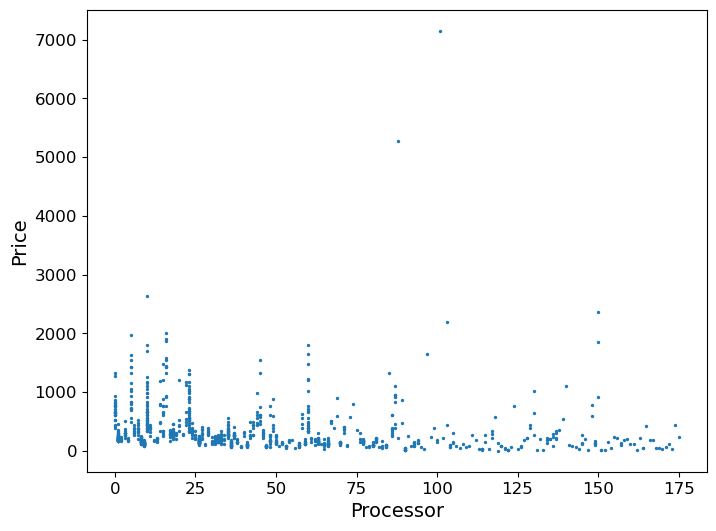

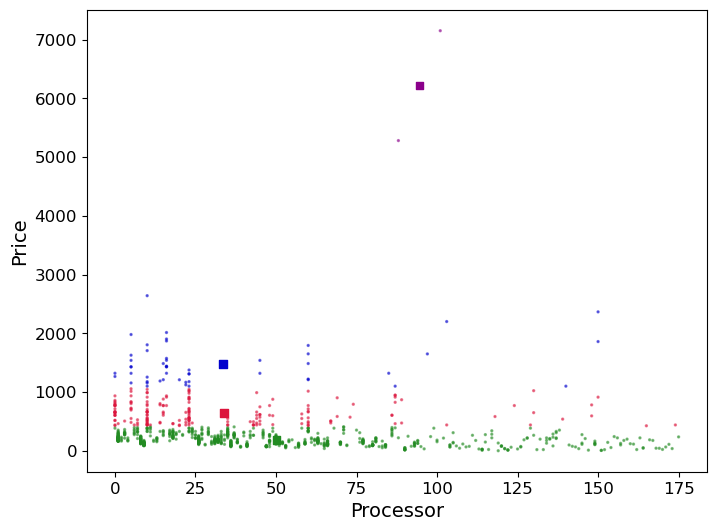

,model,Price_Euro,processor,processor_type_code,core_type_code,clock_speed_code,centroid,error
0,OnePlus 11 5G,604.99,"Snapdragon 8 Gen2, Octa Core, 3.2 GHz Processor",0,0,0,0,8.371468e+06
1,OnePlus Nord CE 2 Lite 5G,219.88,"Snapdragon 695, Octa Core, 2.2 GHz Processor",1,0,1,3,1.192683e+07
2,Samsung Galaxy A14 5G,181.49,"Exynos 1330, Octa Core, 2.4 GHz Processor",2,0,2,3,5.556286e+06
3,Motorola Moto G62 5G,164.99,"Snapdragon 695, Octa Core, 2.2 GHz Processor",1,0,1,3,8.589521e+06
4,Realme 10 Pro Plus,274.99,"Dimensity 1080, Octa Core, 2.6 GHz Processor",3,0,3,3,9.697981e+07
5,Samsung Galaxy F23 5G (6GB RAM + 128GB),186.99,"Snapdragon 750G, Octa Core, 2.2 GHz Processor",4,0,1,3,4.540263e+06
6,Apple iPhone 14,725.99,"Bionic A15, Hexa Core, 3.22 GHz Processor",5,1,4,0,5.042157e+07
7,Xiaomi Redmi Note 12 Pro Plus,329.99,"Dimensity 1080, Octa Core, 2.6 GHz Processor",3,0,3,3,5.052454e+08
8,Nothing Phone 1,294.24,"Snapdragon 778G Plus, Octa Core, 2.5 GHz Proce...",6,0,5,3,1.770537e+08
9,OnePlus Nord 2T 5G,318.99,"Dimensity 1300, Octa Core, 3 GHz Processor",7,0,6,3,3.650566e+08


In [6]:
def price_processor_analysis(df):

    fig, ax = plt.subplots(figsize=(8, 6))
    # Scatter plot of the data points (Processor (int) vs Price)
    plt.scatter(x=df['processor_type_code'], y=df['Price_Euro'], s=2)
    ax.set_xlabel(r'Processor', fontsize=14)
    ax.set_ylabel(r'Price', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    # Apply the k-means algorithm
    np.random.seed(42)  # Set seed to 42 for reproducibility
    k = 4               # Number of clusters (for low range phones, medium range phones, high range phones, and luxury phones)
    df['centroid'], df['error'], centroids =  kmeans(df[['processor_type_code','Price_Euro']], k) # Apply k-means and get the centroids

    # Colors for the clusters/centrods in the scatter plot
    customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta", "forestgreen"])

    # Plot the scatter plot for the data points now in different colour clusters (circle markers)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(x=df['processor_type_code'], y=df['Price_Euro'],  marker = 'o', 
                c=df['centroid'].astype('category'), 
                cmap = customcmap, s=2, alpha=0.5)
    # Plot the centroids in the same plot (square markers)
    plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
                marker = 's', s=30, c=[0, 1, 2, 3], 
                cmap = customcmap)
    ax.set_xlabel(r'Processor', fontsize=14)
    ax.set_ylabel(r'Price', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    return df

# Map the processor col to int using one-hot encoding (same processor type will have the same code)
df = one_hot_enco_proc(df)
# Clustering
df = price_processor_analysis(df)
# Display data after clustering
df[['model','Price_Euro','processor','processor_type_code','core_type_code','clock_speed_code','centroid','error']].head(10)

### Association Rule Mining for each cluster

In [7]:
def assoc_mining_proc(df, c, min_sup=0.2, min_thr=0.6):
    # Filter the dataframe by the cluster
    df = df[df['centroid'] == c]
    # Dataframe with all processor characteristics
    pr = pd.DataFrame(df['processor']);
    
    pr = pr.replace('\u2009', '', regex=True) # Removes the thin space character from col processor
    # Split the processor column by comma into lists
    data = list(pr["processor"].apply(lambda x:x.split(","))) # spit the processor column by comma into lists

    # Association rules
    freq_items, pr_ar = assoc_rules(data, min_sup, min_thr) 
    return freq_items, pr_ar

### Low-End phones

##### Frequent Items

In [8]:
freq_items3, pr_ar3 = assoc_mining_proc(df, 3, 0.1, 0.1) 
freq_items3

Processing 20 combinations | Sampling itemset size 2


,support,itemsets
0,0.169427,( 2.2GHz Processor)
1,0.109554,( 2.3GHz Processor)
2,0.157962,( 2.4GHz Processor)
3,0.185987,( 2GHz Processor)
4,0.871338,( Octa Core)
5,0.168153,"( 2.2GHz Processor, Octa Core)"
6,0.109554,"( 2.3GHz Processor, Octa Core)"
7,0.157962,"( 2.4GHz Processor, Octa Core)"
8,0.165605,"( 2GHz Processor, Octa Core)"


##### Association Rules

In [9]:
pr_ar3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 2.2GHz Processor),( Octa Core),0.169427,0.871338,0.168153,0.992481,1.139032,0.020525,17.112102,0.146960
1,( Octa Core),( 2.2GHz Processor),0.871338,0.169427,0.168153,0.192982,1.139032,0.020525,1.029189,0.948695
2,( 2.3GHz Processor),( Octa Core),0.109554,0.871338,0.109554,1.000000,1.147661,0.014096,inf,0.144492
3,( Octa Core),( 2.3GHz Processor),0.871338,0.109554,0.109554,0.125731,1.147661,0.014096,1.018503,1.000000
4,( 2.4GHz Processor),( Octa Core),0.157962,0.871338,0.157962,1.000000,1.147661,0.020324,inf,0.152799
5,( Octa Core),( 2.4GHz Processor),0.871338,0.157962,0.157962,0.181287,1.147661,0.020324,1.028490,1.000000
6,( 2GHz Processor),( Octa Core),0.185987,0.871338,0.165605,0.890411,1.021890,0.003547,1.174045,0.026315
7,( Octa Core),( 2GHz Processor),0.871338,0.185987,0.165605,0.190058,1.021890,0.003547,1.005027,0.166489


### Mid-Range phones

##### Frequent Items

In [10]:
freq_items0, pr_ar0 = assoc_mining_proc(df, 0, 0.1, 0.3)
freq_items0

Processing 4 combinations | Sampling itemset size 43


,support,itemsets
0,0.311475,( 3.2GHz Processor)
1,0.158470,( 3GHz Processor)
2,0.109290,( Hexa Core)
3,0.825137,( Octa Core)
4,0.114754,(Snapdragon 8 Gen2)
5,0.114754,(Snapdragon 8+ Gen1)
6,0.311475,"( 3.2GHz Processor, Octa Core)"
7,0.114754,"(Snapdragon 8 Gen2, 3.2GHz Processor)"
8,0.114754,"(Snapdragon 8+ Gen1, 3.2GHz Processor)"
9,0.158470,"( 3GHz Processor, Octa Core)"


##### Association Rules

In [11]:
pr_ar0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 3.2GHz Processor),( Octa Core),0.311475,0.825137,0.311475,1.000000,1.211921,0.054466,inf,0.253968
1,( Octa Core),( 3.2GHz Processor),0.825137,0.311475,0.311475,0.377483,1.211921,0.054466,1.106034,1.000000
2,(Snapdragon 8 Gen2),( 3.2GHz Processor),0.114754,0.311475,0.114754,1.000000,3.210526,0.079011,inf,0.777778
3,( 3.2GHz Processor),(Snapdragon 8 Gen2),0.311475,0.114754,0.114754,0.368421,3.210526,0.079011,1.401639,1.000000
4,(Snapdragon 8+ Gen1),( 3.2GHz Processor),0.114754,0.311475,0.114754,1.000000,3.210526,0.079011,inf,0.777778
5,( 3.2GHz Processor),(Snapdragon 8+ Gen1),0.311475,0.114754,0.114754,0.368421,3.210526,0.079011,1.401639,1.000000
6,( 3GHz Processor),( Octa Core),0.158470,0.825137,0.158470,1.000000,1.211921,0.027711,inf,0.207792
7,(Snapdragon 8 Gen2),( Octa Core),0.114754,0.825137,0.114754,1.000000,1.211921,0.020066,inf,0.197531
8,(Snapdragon 8+ Gen1),( Octa Core),0.114754,0.825137,0.114754,1.000000,1.211921,0.020066,inf,0.197531
9,"(Snapdragon 8 Gen2, 3.2GHz Processor)",( Octa Core),0.114754,0.825137,0.114754,1.000000,1.211921,0.020066,inf,0.197531


### High-End phones

##### Frequent Items

In [12]:
freq_items1, pr_ar1 = assoc_mining_proc(df, 1, 0.1, 0.2)
freq_items1

Processing 33 combinations | Sampling itemset size 3


,support,itemsets
0,0.14,( 2.84GHz Processor)
1,0.14,( 3.22GHz Processor)
2,0.20,( 3.2GHz Processor)
3,0.10,( 3GHz Processor)
4,0.20,( Hexa Core)
5,0.14,( Hexa Core Processor)
6,0.58,( Octa Core)
7,0.18,(Bionic A16)
8,0.14,(Bionic A15)
9,0.14,"( 2.84GHz Processor, Octa Core)"


##### Association Rules

In [13]:
pr_ar1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 2.84GHz Processor),( Octa Core),0.14,0.58,0.14,1.000000,1.724138,0.0588,inf,0.488372
1,( Octa Core),( 2.84GHz Processor),0.58,0.14,0.14,0.241379,1.724138,0.0588,1.133636,1.000000
2,( Hexa Core),( 3.22GHz Processor),0.20,0.14,0.14,0.700000,5.000000,0.1120,2.866667,1.000000
3,( 3.22GHz Processor),( Hexa Core),0.14,0.20,0.14,1.000000,5.000000,0.1120,inf,0.930233
4,(Bionic A15),( 3.22GHz Processor),0.14,0.14,0.14,1.000000,7.142857,0.1204,inf,1.000000
5,( 3.22GHz Processor),(Bionic A15),0.14,0.14,0.14,1.000000,7.142857,0.1204,inf,1.000000
6,( 3.2GHz Processor),( Octa Core),0.20,0.58,0.20,1.000000,1.724138,0.0840,inf,0.525000
7,( Octa Core),( 3.2GHz Processor),0.58,0.20,0.20,0.344828,1.724138,0.0840,1.221053,1.000000
8,( 3GHz Processor),( Octa Core),0.10,0.58,0.10,1.000000,1.724138,0.0420,inf,0.466667
9,(Bionic A15),( Hexa Core),0.14,0.20,0.14,1.000000,5.000000,0.1120,inf,0.930233


### Luxury phones

##### Frequent Items

In [14]:
freq_items2, pr_ar2 = assoc_mining_proc(df, 2)
freq_items2

Processing 4 combinations | Sampling itemset size 43


,support,itemsets
0,0.5,( 1.5GHz Processor)
1,0.5,( 2.8GHz Processor)
2,1.0,( Octa Core)
3,0.5,(Snapdragon 855)
4,0.5,(Snapdragon 801)
5,0.5,"( 1.5GHz Processor, Octa Core)"
6,0.5,"( 1.5GHz Processor, Snapdragon 801)"
7,0.5,"( 2.8GHz Processor, Octa Core)"
8,0.5,"( 2.8GHz Processor, Snapdragon 855)"
9,0.5,"( Octa Core, Snapdragon 855)"


##### Association Rules

In [15]:
pr_ar2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 1.5GHz Processor),( Octa Core),0.5,1.0,0.5,1.0,1.0,0.00,inf,0.0
1,( 1.5GHz Processor),(Snapdragon 801),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0
2,(Snapdragon 801),( 1.5GHz Processor),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0
3,( 2.8GHz Processor),( Octa Core),0.5,1.0,0.5,1.0,1.0,0.00,inf,0.0
4,( 2.8GHz Processor),(Snapdragon 855),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0
5,(Snapdragon 855),( 2.8GHz Processor),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0
6,(Snapdragon 855),( Octa Core),0.5,1.0,0.5,1.0,1.0,0.00,inf,0.0
7,(Snapdragon 801),( Octa Core),0.5,1.0,0.5,1.0,1.0,0.00,inf,0.0
8,"( 1.5GHz Processor, Snapdragon 801)",( Octa Core),0.5,1.0,0.5,1.0,1.0,0.00,inf,0.0
9,"( Octa Core, Snapdragon 801)",( 1.5GHz Processor),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0


## 2. Price - RAM
### Cluster Analysis - kMeans Algorithm

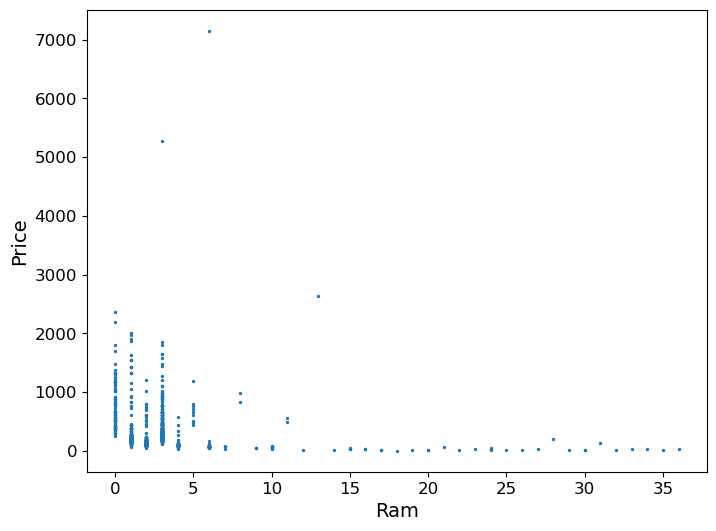

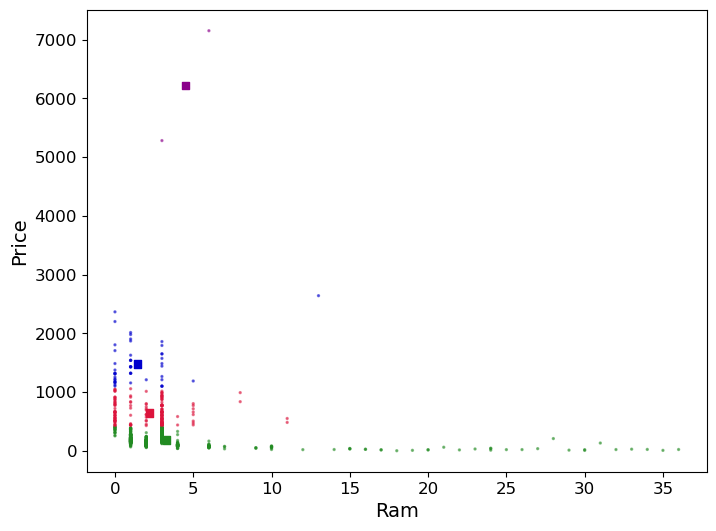

,model,Price_Euro,ram,ram_type_code,storage_type_code,centroid,error
0,OnePlus 11 5G,604.99,"12 GB RAM, 256 GB inbuilt",0,0,0,3.075594e+06
1,OnePlus Nord CE 2 Lite 5G,219.88,"6 GB RAM, 128 GB inbuilt",1,1,3,1.086765e+06
2,Samsung Galaxy A14 5G,181.49,"4 GB RAM, 64 GB inbuilt",2,2,3,1.590354e+03
3,Motorola Moto G62 5G,164.99,"6 GB RAM, 128 GB inbuilt",1,1,3,2.701349e+05
4,Realme 10 Pro Plus,274.99,"6 GB RAM, 128 GB inbuilt",1,1,3,5.820791e+07
5,Samsung Galaxy F23 5G (6GB RAM + 128GB),186.99,"6 GB RAM, 128 GB inbuilt",1,1,3,3.224125e+01
6,Apple iPhone 14,725.99,"6 GB RAM, 128 GB inbuilt",1,1,0,3.932648e+07
7,Xiaomi Redmi Note 12 Pro Plus,329.99,"8 GB RAM, 256 GB inbuilt",3,0,3,4.102291e+08
8,Nothing Phone 1,294.24,"8 GB RAM, 128 GB inbuilt",3,1,3,1.289709e+08
9,OnePlus Nord 2T 5G,318.99,"8 GB RAM, 128 GB inbuilt",3,1,3,2.973606e+08


In [16]:
def price_ram_analysis(df):
    # Scatter plot of the data points (Ram (int) vs Price)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(x=df['ram_type_code'], y=df['Price_Euro'], s=2)
    ax.set_xlabel(r'Ram', fontsize=14)
    ax.set_ylabel(r'Price', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    # Apply the k-means algorithm to the dataset
    np.random.seed(42) 
    k = 4               # Number of clusters (for low range phones, medium range phones, high range phones, and luxury phones)
    df['centroid'], df['error'], centroids =  kmeans(df[['ram_type_code','Price_Euro']], k)

    # Colors for the clusters in the scatter plot
    customcmap = ListedColormap(["crimson", "mediumblue", "darkmagenta", "forestgreen"])

    # Plot the scatter plot for the data points now in different colour clusters (circle markers)
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(x=df['ram_type_code'], y=df['Price_Euro'],  marker = 'o', 
                c=df['centroid'].astype('category'), 
                cmap = customcmap, s=2, alpha=0.5)
    # Plot the centroids in the same plot (square markers)
    plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  
                marker = 's', s=30, c=[0, 1, 2, 3], 
                cmap = customcmap)
    ax.set_xlabel(r'Ram', fontsize=14)
    ax.set_ylabel(r'Price', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    return df

 # Map the ram col to int using one-hot encoding
df = one_hot_enco_ram(df)
# Clustering
df = price_ram_analysis(df)
# Display data after clustering
df[['model','Price_Euro','ram','ram_type_code','storage_type_code','centroid','error']].head(10)

### Association Rule Mining for each cluster

In [17]:
def assoc_mining_ram(df, c, min_sup=0.2, min_thr=0.6):
    # Filter the dataframe by the cluster
    df = df[df['centroid'] == c]
    # Dataframe with all ram characteristics
    pr = pd.DataFrame(df['ram'])
    # Split the processor column by comma into lists
    data = list(pr["ram"].apply(lambda x:x.split(",") ))
    # Association rules
    freq_items, pr_ar = assoc_rules(data, min_sup, min_thr)
    return freq_items, pr_ar

### Low-End phones

##### Frequent Items

In [18]:
freq_items3, pr_ar3 = assoc_mining_ram(df, 3, 0.1, 0.4)
freq_items3

Processing 9 combinations | Sampling itemset size 32


,support,itemsets
0,0.541401,( 128 GB inbuilt)
1,0.234395,( 64 GB inbuilt)
2,0.257325,(4 GB RAM)
3,0.259873,(6 GB RAM)
4,0.296815,(8 GB RAM)
5,0.222930,"( 128 GB inbuilt, 6 GB RAM)"
6,0.245860,"(8 GB RAM, 128 GB inbuilt)"
7,0.175796,"( 64 GB inbuilt, 4 GB RAM)"


##### Association Rules

In [19]:
pr_ar3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 128 GB inbuilt),(6 GB RAM),0.541401,0.259873,0.222930,0.411765,1.584487,0.082235,1.258217,0.804365
1,(6 GB RAM),( 128 GB inbuilt),0.259873,0.541401,0.222930,0.857843,1.584487,0.082235,3.226005,0.498402
2,(8 GB RAM),( 128 GB inbuilt),0.296815,0.541401,0.245860,0.828326,1.529967,0.085164,2.671338,0.492603
3,( 128 GB inbuilt),(8 GB RAM),0.541401,0.296815,0.245860,0.454118,1.529967,0.085164,1.288162,0.755325
4,( 64 GB inbuilt),(4 GB RAM),0.234395,0.257325,0.175796,0.750000,2.914604,0.115481,2.970701,0.858014
5,(4 GB RAM),( 64 GB inbuilt),0.257325,0.234395,0.175796,0.683168,2.914604,0.115481,2.416441,0.884505


### Mid-Range phones

##### Frequent Items

In [20]:
freq_items0, pr_ar0 = assoc_mining_ram(df, 0, 0.1, 0.2)
freq_items0

Processing 3 combinations | Sampling itemset size 32


,support,itemsets
0,0.475410,( 128 GB inbuilt)
1,0.426230,( 256 GB inbuilt)
2,0.267760,(12 GB RAM)
3,0.508197,(8 GB RAM)
4,0.377049,"(8 GB RAM, 128 GB inbuilt)"
5,0.229508,"(12 GB RAM, 256 GB inbuilt)"
6,0.131148,"( 256 GB inbuilt, 8 GB RAM)"


##### Association Rules

In [21]:
pr_ar0

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(8 GB RAM),( 128 GB inbuilt),0.508197,0.475410,0.377049,0.741935,1.560623,0.135447,2.032787,0.730435
1,( 128 GB inbuilt),(8 GB RAM),0.475410,0.508197,0.377049,0.793103,1.560623,0.135447,2.377049,0.684783
2,(12 GB RAM),( 256 GB inbuilt),0.267760,0.426230,0.229508,0.857143,2.010989,0.115381,4.016393,0.686567
3,( 256 GB inbuilt),(12 GB RAM),0.426230,0.267760,0.229508,0.538462,2.010989,0.115381,1.586521,0.876190
4,( 256 GB inbuilt),(8 GB RAM),0.426230,0.508197,0.131148,0.307692,0.605459,-0.085461,0.710383,-0.531773
5,(8 GB RAM),( 256 GB inbuilt),0.508197,0.426230,0.131148,0.258065,0.605459,-0.085461,0.773343,-0.569892


### High-End phones

##### Frequent Items

In [22]:
freq_items1, pr_ar1 = assoc_mining_ram(df, 1, 0.1, 0.3)
freq_items1

Processing 15 combinations | Sampling itemset size 3


,support,itemsets
0,0.22,( 128 GB inbuilt)
1,0.10,( 1 TB inbuilt)
2,0.42,( 256 GB inbuilt)
3,0.22,( 512 GB inbuilt)
4,0.38,(12 GB RAM)
5,0.32,(6 GB RAM)
6,0.24,(8 GB RAM)
7,0.10,"(8 GB RAM, 128 GB inbuilt)"
8,0.22,"(12 GB RAM, 256 GB inbuilt)"
9,0.10,"( 256 GB inbuilt, 6 GB RAM)"


##### Association Rules

In [23]:
pr_ar1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(8 GB RAM),( 128 GB inbuilt),0.24,0.22,0.10,0.416667,1.893939,0.0472,1.337143,0.621053
1,( 128 GB inbuilt),(8 GB RAM),0.22,0.24,0.10,0.454545,1.893939,0.0472,1.393333,0.605128
2,(12 GB RAM),( 256 GB inbuilt),0.38,0.42,0.22,0.578947,1.378446,0.0604,1.377500,0.442815
3,( 256 GB inbuilt),(12 GB RAM),0.42,0.38,0.22,0.523810,1.378446,0.0604,1.302000,0.473354
4,(6 GB RAM),( 256 GB inbuilt),0.32,0.42,0.10,0.312500,0.744048,-0.0344,0.843636,-0.335937
5,(8 GB RAM),( 256 GB inbuilt),0.24,0.42,0.10,0.416667,0.992063,-0.0008,0.994286,-0.010417
6,( 512 GB inbuilt),(12 GB RAM),0.22,0.38,0.10,0.454545,1.196172,0.0164,1.136667,0.210256


### Luxury phones

##### Frequent Items

In [24]:
freq_items2, pr_ar2 = assoc_mining_ram(df, 2)
freq_items2

Processing 3 combinations | Sampling itemset size 32


,support,itemsets
0,0.5,( 256 GB inbuilt)
1,0.5,( 64 GB inbuilt)
2,0.5,(2 GB RAM)
3,0.5,(8 GB RAM)
4,0.5,"( 256 GB inbuilt, 8 GB RAM)"
5,0.5,"( 64 GB inbuilt, 2 GB RAM)"


##### Association Rules

In [25]:
pr_ar2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,( 256 GB inbuilt),(8 GB RAM),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0
1,(8 GB RAM),( 256 GB inbuilt),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0
2,( 64 GB inbuilt),(2 GB RAM),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0
3,(2 GB RAM),( 64 GB inbuilt),0.5,0.5,0.5,1.0,2.0,0.25,inf,1.0


# References

### Dataset 
- [Kaggle: Smartphone Dataset for Analysis](https://www.kaggle.com/datasets/nishantdeswal1810/smartphones/data)

### Clustering/Association Rules
- [EClass](https://eclass.uniwa.gr/modules/document/index.php?course=ICE359&openDir=/642559dbNqZt)

### One Hot Encoding
- [One Hot Encoding in Machine Learning - GEEKSFORGEEKS](https://www.geeksforgeeks.org/ml-one-hot-encoding/amp/):
We used this reference to understand what One Hot Encoding algorithm does as this website has a simple example to demonstrate it.

- [StackOverFlow Question - When to use pd.factorize or pd.getdummies](https://stackoverflow.com/questions/40336502/want-to-know-the-diff-among-pd-factorize-pd-get-dummies-sklearn-preprocessing): One answer demonstrates to use pd.factorize() and not pd.getdummies() for one hot encoding (like the first reference does) as the resutl from pd.getdummies has n dimensions (as many as the different values in each column) and pd.factorize() one dimension (one column with different code for each distinct value). We need one column one hot encoding for our cluster analysis.

- [Pandas.factorize() - GEEKSFORGEEKS](https://www.geeksforgeeks.org/python-pandas-factorize/): Here we looked how does pd.factorize() works for the numeric representation and unique values.